In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import os

# CMA aging Atlas: Brain
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Brain data, Smart-seq2 assay in .h5ad format was used for further analysis.

In [3]:
# Creating folder for outputs
os.makedirs('../Khwaja_et_al_outputs/Brain')

## Importing and preprocessing data

In [2]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/Brain_non_myeloid.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [3]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in enumerate(barcode.index):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2600.21it/s]


In [4]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score
index,,,,,,,,,,,,,,,,,,,,,
C4_B001059_B009342_S52.mm10-plus-0-0,Neurons,18m,C4_B001059,nan,facs,18_46_F,Striatum,2754,3662.028564,3,...,NCBITaxon:10090,oligodendrocyte,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.199900
E10_B001059_B009342_S106.mm10-plus-0-0,Neurons,18m,E10_B001059,nan,facs,18_46_F,Striatum,2701,3448.414795,3,...,NCBITaxon:10090,oligodendrocyte,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,0.057767
E22_B001059_B009342_S118.mm10-plus-0-0,Neurons,18m,E22_B001059,nan,facs,18_46_F,Striatum,1969,4171.871582,15,...,NCBITaxon:10090,"CD8-positive, alpha-beta T cell",Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.207509
F5_B001059_B009342_S125.mm10-plus-0-0,Neurons,18m,F5_B001059,nan,facs,18_46_F,Striatum,1542,2782.537354,3,...,NCBITaxon:10090,oligodendrocyte,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.307646
G18_B001059_B009342_S162.mm10-plus-0-0,Neurons,18m,G18_B001059,nan,facs,18_46_F,Striatum,605,998.277710,9,...,NCBITaxon:10090,microglial cell,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.707019


## CMA net score/cell type (fold over whole tissue)

In [8]:
# Checking n of mice 
list(barcode['mouse.id'].unique())

['18_46_F',
 '18_47_F',
 '18_45_M',
 '18_53_M',
 '24_60_M',
 '24_59_M',
 '24_58_M',
 '3_38_F',
 '3_56_F',
 '3_10_M',
 '3_9_M',
 '3_11_M',
 '3_8_M',
 '3_39_F']

**Mice n for Liver**
    - Young females: 3
    - Young males: 4
    - Old females: 2
    - Old males: 5

In [5]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
C4_B001059_B009342_S52.mm10-plus-0-0,Neurons,18m,C4_B001059,nan,facs,18_46_F,Striatum,2754,3662.028564,3,...,oligodendrocyte,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.199900,18-24m
E10_B001059_B009342_S106.mm10-plus-0-0,Neurons,18m,E10_B001059,nan,facs,18_46_F,Striatum,2701,3448.414795,3,...,oligodendrocyte,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,0.057767,18-24m
E22_B001059_B009342_S118.mm10-plus-0-0,Neurons,18m,E22_B001059,nan,facs,18_46_F,Striatum,1969,4171.871582,15,...,"CD8-positive, alpha-beta T cell",Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.207509,18-24m
F5_B001059_B009342_S125.mm10-plus-0-0,Neurons,18m,F5_B001059,nan,facs,18_46_F,Striatum,1542,2782.537354,3,...,oligodendrocyte,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.307646,18-24m
G18_B001059_B009342_S162.mm10-plus-0-0,Neurons,18m,G18_B001059,nan,facs,18_46_F,Striatum,605,998.277710,9,...,microglial cell,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.707019,18-24m


In [10]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
C4_B001059_B009342_S52.mm10-plus-0-0,Neurons,18m,C4_B001059,nan,facs,18_46_F,Striatum,2754,3662.028564,3,...,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.199900,18-24m,-0.263421
E10_B001059_B009342_S106.mm10-plus-0-0,Neurons,18m,E10_B001059,nan,facs,18_46_F,Striatum,2701,3448.414795,3,...,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,0.057767,18-24m,-0.005754
E22_B001059_B009342_S118.mm10-plus-0-0,Neurons,18m,E22_B001059,nan,facs,18_46_F,Striatum,1969,4171.871582,15,...,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.207509,18-24m,-0.271031
F5_B001059_B009342_S125.mm10-plus-0-0,Neurons,18m,F5_B001059,nan,facs,18_46_F,Striatum,1542,2782.537354,3,...,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.307646,18-24m,-0.371168
G18_B001059_B009342_S162.mm10-plus-0-0,Neurons,18m,G18_B001059,nan,facs,18_46_F,Striatum,605,998.277710,9,...,Smart-seq2,normal,Mus musculus,female,brain,na,18 month-old stage,-0.707019,18-24m,-0.770541


In [7]:
barcode.cell_type.unique()

['oligodendrocyte', 'CD8-positive, alpha-beta T cell', 'microglial cell', 'astrocyte', 'ependymal cell', ..., 'T cell', 'neuronal stem cell', 'mature NK T cell', 'medium spiny neuron', 'macrophage']
Length: 17
Categories (17, object): ['Bergmann glial cell', 'CD8-positive, alpha-beta T cell', 'T cell', 'astrocyte', ..., 'neuron', 'neuronal stem cell', 'oligodendrocyte', 'oligodendrocyte precursor cell']

In [11]:
cells = ['neuron', 'interneuron', 'astrocyte', 'oligodendrocyte']

### Cell types stats

In [8]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['cell_type']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [9]:
normalidad(barcode, tipo=cells, años=['3m', '18-24m'])

,Cell,Age,n,Stat,p value,Result
0,neuron,3m,154,1.982074,0.371192,Normal
1,neuron,18-24m,330,4.238877,0.120099,Normal
2,interneuron,3m,83,0.417086,0.811766,Normal
3,interneuron,18-24m,157,0.167444,0.919687,Normal
4,astrocyte,3m,454,1.935582,0.379921,Normal
5,astrocyte,18-24m,138,8.739245,0.012656,Not normal
6,oligodendrocyte,3m,1396,4.182258,0.123548,Normal
7,oligodendrocyte,18-24m,698,1.087405,0.580595,Normal


In [10]:
# Calculating T test for normally distributed cell types
for i in ['neuron', 'interneuron', 'oligodendrocyte']:
    # First Levene test for equal variances
    group3 = list(barcode[barcode.cell_type==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.cell_type==i][barcode.new_age=='18-24m']['net_score'])
    print('Levene test for {}'.format(i.title()))
    stat, p = stats.levene(group3, group18_24)
    print("Levene's test pval for {} = {}".format(i.title(), p))
    
    # T test
    if p < 0.05:
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=False)
        print('T test for {}, with no equal var.'.format(i))
        print("T test pval = " + str(p2))
        print('\n')
        
    else:
        stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=True)
        print('T test for {}, assuming equal var.'.format(i))
        print("T test pval = " + str(p2))
        print('\n')

Levene test for Neuron
Levene's test pval for Neuron = 0.007952822618855562
T test for neuron, with no equal var.
T test pval = 0.00017534254256610488


Levene test for Interneuron
Levene's test pval for Interneuron = 0.26072640986014467
T test for interneuron, assuming equal var.
T test pval = 0.38982432855856586


Levene test for Oligodendrocyte
Levene's test pval for Oligodendrocyte = 0.002060613273649745
T test for oligodendrocyte, with no equal var.
T test pval = 4.091082329732512e-07




C:\Users\Adrian\AppData\Local\Temp\ipykernel_7320\1608487262.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.cell_type==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_7320\1608487262.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.cell_type==i][barcode.new_age=='18-24m']['net_score'])


In [11]:
# Calculating MWU test for not normally distributed cell types
group3 = list(barcode[barcode.cell_type=='astrocyte'][barcode.new_age=='3m']['net_score'])
group18_24 = list(barcode[barcode.cell_type=='astrocyte'][barcode.new_age=='18-24m']['net_score'])
print('{} statistics'.format(i.title()))
stat, p = stats.mannwhitneyu(group3, group18_24)
print("MWU test pval = " + str(p))
print('\n')

Oligodendrocyte statistics
MWU test pval = 1.2271386085748616e-11




C:\Users\Adrian\AppData\Local\Temp\ipykernel_7320\1555879450.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.cell_type=='astrocyte'][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_7320\1555879450.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.cell_type=='astrocyte'][barcode.new_age=='18-24m']['net_score'])


### Net score graph

C:\Users\Adrian\AppData\Local\Temp\ipykernel_9280\1712481659.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y1= np.mean(barcode[barcode.cell_type =='neuron'][barcode.new_age=='18-24m']['net_score']) - (0.03)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9280\1712481659.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y2= np.mean(barcode[barcode.cell_type =='astrocyte'][barcode.new_age=='18-24m']['net_score']) - (0.03)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9280\1712481659.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y3= np.mean(barcode[barcode.cell_type =='oligodendrocyte'][barcode.new_age=='18-24m']['net_score']) - (0.03)


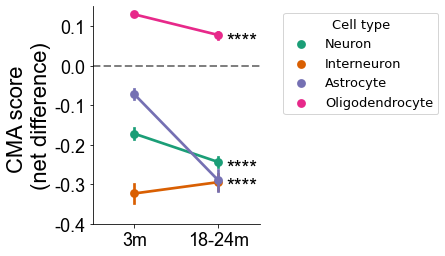

In [11]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='net_score', data=barcode, hue='cell_type', order=["3m", "18-24m"], 
              hue_order=["neuron", 'interneuron', 'astrocyte', 'oligodendrocyte'], palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.40, 0.15) 
ax.set_yticks([-0.40, -0.30, -0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.40, -0.30, -0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})

# Legend
celulas = ['Neuron', 'Interneuron', 'Astrocyte', 'Oligodendrocyte']
h, l = ax.get_legend_handles_labels()
ax.legend(h, celulas, bbox_to_anchor=(1.1, 1), title="Cell type", title_fontsize = "13", fontsize=13) 

# Stats
x1= 1.1   
y1= np.mean(barcode[barcode.cell_type =='neuron'][barcode.new_age=='18-24m']['net_score']) - (0.03)
y2= np.mean(barcode[barcode.cell_type =='astrocyte'][barcode.new_age=='18-24m']['net_score']) - (0.03)
y3= np.mean(barcode[barcode.cell_type =='oligodendrocyte'][barcode.new_age=='18-24m']['net_score']) - (0.03)

plt.text(x1, y1, "****", fontsize=20, **hfont)
plt.text(x1, y2, "****", fontsize=20, **hfont)
plt.text(x1, y3, "****", fontsize=20, **hfont)

plt.savefig('../Khwaja_et_al_outputs/Brain/Brain_nscorrect.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data 

In [12]:
# Extracting raw values for pointplot graphic
long = []
celula = []
age = []
mean=[]
sem=[]

for x in cells:
    for y in ['3m', '18-24m']:
        n = len(barcode[barcode['cell_type']== x][barcode['new_age']== y].index)
        m = np.mean(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score'])
        s = stats.sem(np.array(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score']))
        
        long.append(n)
        celula.append(x)
        age.append(y)
        mean.append(m)
        sem.append(s)
        
df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "n": long, "Mean":mean, "SEM": sem})
df_raw.to_excel('../Khwaja_et_al_outputs/Brain/Raw_data.xlsx', 'Netsc', index=False)

df_raw

C:\Users\Adrian\AppData\Local\Temp\ipykernel_9280\2440920778.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== x][barcode['new_age']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9280\2440920778.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9280\2440920778.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(np.array(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score']))


,Cell_type,Age,n,Mean,SEM
0,neuron,3m,154,-0.172156,0.014220
1,neuron,18-24m,330,-0.243685,0.012408
2,interneuron,3m,83,-0.323209,0.024440
3,interneuron,18-24m,157,-0.294660,0.020332
4,astrocyte,3m,454,-0.072783,0.013471
5,astrocyte,18-24m,138,-0.289790,0.026252
6,oligodendrocyte,3m,1396,0.129664,0.005403
7,oligodendrocyte,18-24m,698,0.077614,0.008678


## CMA net score/cell type & sex (folde over whole tissue)

### Stats

In [13]:
# Calculating n of cells per cell type, sex and age
for i in cells:
    print(i.title() + " length:" + str(len(barcode[barcode["cell_type"]==i].index)))
    print(barcode[barcode["cell_type"]==i].value_counts(["sex", "new_age"]))
    print("\n")

Neuron length:484
sex     new_age
male    18-24m     254
        3m         134
female  18-24m      76
        3m          20
dtype: int64


Interneuron length:240
sex     new_age
female  18-24m     81
male    18-24m     76
        3m         54
female  3m         29
dtype: int64


Astrocyte length:592
sex     new_age
male    3m         352
female  3m         102
        18-24m      82
male    18-24m      56
dtype: int64


Oligodendrocyte length:2094
sex     new_age
male    3m         1234
female  18-24m      389
male    18-24m      309
female  3m          162
dtype: int64




In [14]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode[barcode['cell_type']==i].reset_index()    
    
    # 2-way Anova
    model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Neuron 2-way Anova

                      df     sum_sq   mean_sq          F    PR(>F)
C(new_age)           1.0   0.537232  0.537232  12.006559  0.000578
C(sex)               1.0   0.000052  0.000052   0.001153  0.972928
C(new_age):C(sex)    1.0   0.000697  0.000697   0.015581  0.900714
Residual           480.0  21.477521  0.044745        NaN       NaN


Neuron Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male -0.0281 0.9776       1.0  False
18-24m & female   3m & female -1.1667 0.2463       1.0  False
18-24m & female     3m & male -2.3912 0.0177    0.1061  False
  18-24m & male   3m & female -1.5444 0.1236    0.7419  False
  18-24m & male     3m & male -3.3644 0.0008    0.0051   True
    3m & female     3m & male  0.1504 0.8807       1.0  False
--------------------------

### Graphs

#### Neurons

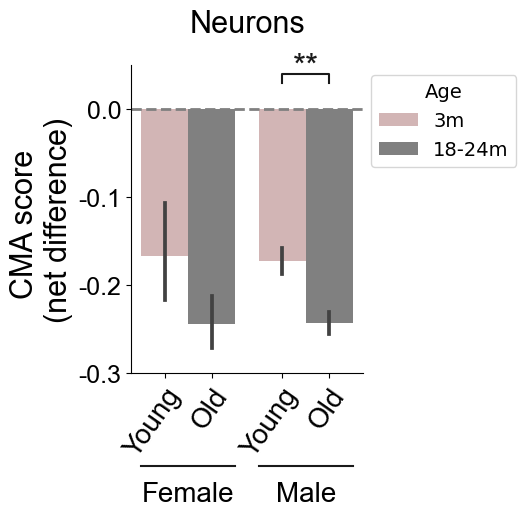

In [91]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.cell_type=='neuron'], hue='new_age', order=["female", "male"], 
            hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
ax.set_yticks([-0.30, -0.20, -0.10, 0.0])
ax.set_yticklabels([-0.30, -0.20, -0.10, 0.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Neurons', fontdict={'family':'Arial', 'size': 22}, y=1.08)
plt.ylim(-0.30, 0.05) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "**", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Neur_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Interneurons

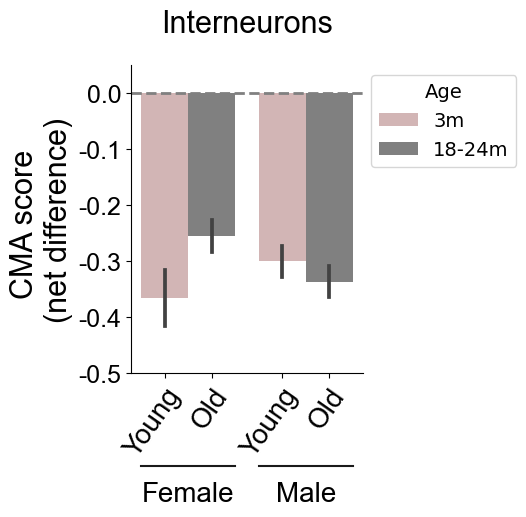

In [90]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.cell_type=='interneuron'], hue='new_age', order=["female", "male"], 
            hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
ax.set_yticks([-0.50, -0.40, -0.30, -0.20, -0.10, 0])
ax.set_yticklabels([-0.50, -0.40,-0.30, -0.20, -0.10, 0.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Interneurons', fontdict={'family':'Arial', 'size': 22}, y=1.08)
plt.ylim(-0.50, 0.05) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Interneur_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Astrocytes

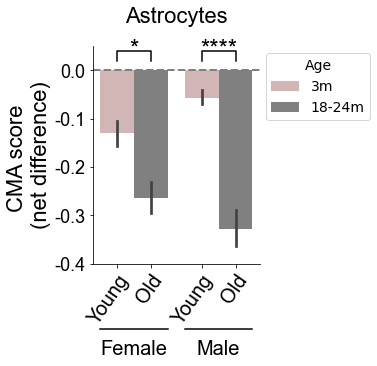

In [17]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.cell_type=='astrocyte'], hue='new_age', order=["female", "male"], 
            hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
ax.set_yticks([-0.40, -0.30, -0.20, -0.10, 0.00])
ax.set_yticklabels([-0.40, -0.30, -0.20, -0.10, 0.00], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Astrocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)
plt.ylim(-0.40, 0.05)  

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.02 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x3, x4 = -0.2, 0.2   
y2, h2, col = 0.02 , 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y2, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Ast_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Oligodendrocytes

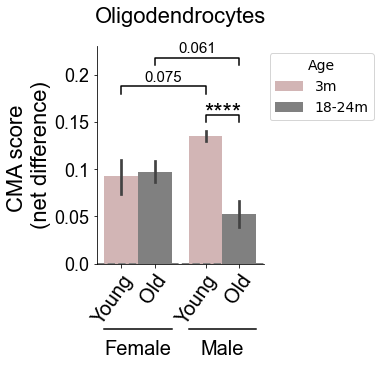

In [18]:
# Figure Oligodend.
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.cell_type=='oligodendrocyte'], hue='new_age', order=["female", "male"], 
            hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
ax.set_yticks([0.00, 0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels([0.00, 0.05, 0.10, 0.15, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Oligodendrocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)
plt.ylim(0, 0.23) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.15 , 0.0075, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.003, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.21 , 0.0075, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+0.01, "0.061", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 15})

x1, x2 = -0.2, 0.8   
y, h, col = 0.18 , 0.0075, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+0.01, "0.075", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 15})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Olig_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [19]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
                s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Brain/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Nsbysex", index=False)
    return(df_raw)

In [20]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_9280\84631770.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9280\84631770.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9280\84631770.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])


,Cell_type,Age,Sex,n,Mean,SEM
0,neuron,3m,female,20,-0.166603,0.056083
1,neuron,3m,male,134,-0.172984,0.014150
2,neuron,18-24m,female,76,-0.244323,0.030807
3,neuron,18-24m,male,254,-0.243494,0.013263
4,interneuron,3m,female,29,-0.365588,0.046992
5,interneuron,3m,male,54,-0.300449,0.027677
6,interneuron,18-24m,female,81,-0.254913,0.028655
7,interneuron,18-24m,male,76,-0.337021,0.028223
8,astrocyte,3m,female,102,-0.130247,0.027688
9,astrocyte,3m,male,352,-0.056132,0.015317


## CMA net score/cell type & sex (folde over each cell type)

In [12]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|                                                                                           | 0/17 [00:00<?, ?it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\2073192913.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
  6%|████▉                                                                              | 1/17 [00:00<00:15,  1.01it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\2073192913.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
C4_B001059_B009342_S52.mm10-plus-0-0,Neurons,18m,C4_B001059,nan,facs,18_46_F,Striatum,2754,3662.028564,3,...,normal,Mus musculus,female,brain,na,18 month-old stage,-0.199900,18-24m,-0.263421,-0.393086
E10_B001059_B009342_S106.mm10-plus-0-0,Neurons,18m,E10_B001059,nan,facs,18_46_F,Striatum,2701,3448.414795,3,...,normal,Mus musculus,female,brain,na,18 month-old stage,0.057767,18-24m,-0.005754,-0.135419
E22_B001059_B009342_S118.mm10-plus-0-0,Neurons,18m,E22_B001059,nan,facs,18_46_F,Striatum,1969,4171.871582,15,...,normal,Mus musculus,female,brain,na,18 month-old stage,-0.207509,18-24m,-0.271031,-0.108464
F5_B001059_B009342_S125.mm10-plus-0-0,Neurons,18m,F5_B001059,nan,facs,18_46_F,Striatum,1542,2782.537354,3,...,normal,Mus musculus,female,brain,na,18 month-old stage,-0.307646,18-24m,-0.371168,-0.500832
G18_B001059_B009342_S162.mm10-plus-0-0,Neurons,18m,G18_B001059,nan,facs,18_46_F,Striatum,605,998.277710,9,...,normal,Mus musculus,female,brain,na,18 month-old stage,-0.707019,18-24m,-0.770541,NaN


### Graphs

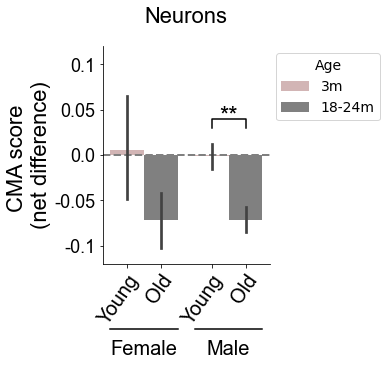

In [15]:
# Figure Neurons
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='neuron'], hue='new_age', order=["female", "male"], 
            hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Neurons', fontdict={'family':'Arial', 'size': 22}, y=1.08)
plt.ylim(-0.12, 0.12) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "**", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Neur_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

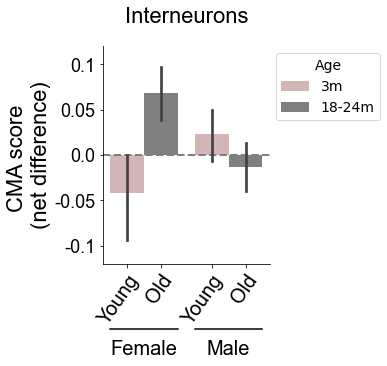

In [18]:
# Figure Interneurons
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='interneuron'], hue='new_age', order=["female", "male"], 
            hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Interneurons', fontdict={'family':'Arial', 'size': 22}, y=1.08)
plt.ylim(-0.12, 0.12) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Interneur_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

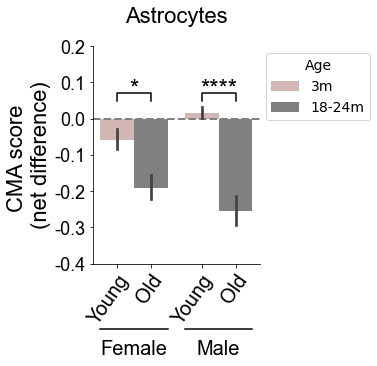

In [19]:
# Figure Astrocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='astrocyte'], hue='new_age', order=["female", "male"], 
            hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
ax.set_yticks([-0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20])
ax.set_yticklabels([-0.40, -0.30, -0.20, -0.10, 0.00, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Astrocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)
plt.ylim(-0.40, 0.2)  

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.05 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x3, x4 = -0.2, 0.2   
y2, h2, col = 0.05 , 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y2, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Ast_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

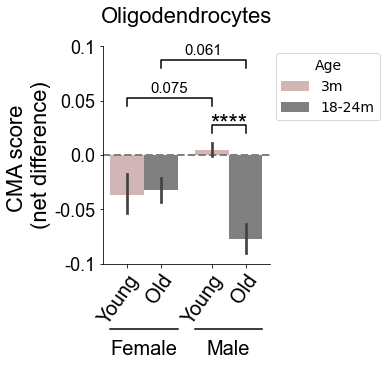

In [21]:
# Figure Oligodend.
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='oligodendrocyte'], hue='new_age', 
            order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Oligodendrocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)
plt.ylim(-0.10, 0.10) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.02 , 0.0075, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.003, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.08 , 0.0075, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+0.01, "0.061", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 15})

x1, x2 = -0.2, 0.8   
y, h, col = 0.045 , 0.0075, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+0.01, "0.075", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 15})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Olig_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [22]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Brain/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="CellNsbysex", index=False)
    return(df_raw)

In [23]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\4219017988.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\4219017988.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\4219017988.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])


,Cell_type,Age,Sex,n,Mean,SEM
0,neuron,3m,female,20,0.005552,0.056083
1,neuron,3m,male,134,-0.000829,0.014150
2,neuron,18-24m,female,76,-0.072167,0.030807
3,neuron,18-24m,male,254,-0.071339,0.013263
4,interneuron,3m,female,29,-0.042379,0.046992
5,interneuron,3m,male,54,0.022759,0.027677
6,interneuron,18-24m,female,81,0.068296,0.028655
7,interneuron,18-24m,male,76,-0.013813,0.028223
8,astrocyte,3m,female,102,-0.057464,0.027688
9,astrocyte,3m,male,352,0.016652,0.015317


## CMA net score/cell type & sex & region

In [42]:
# Checking brain areas available
barcode.subtissue.unique()

['Striatum ', 'Cerebellum ', 'Cortex ', 'Hippocampus ', 'Cortex', 'Hippocampus', 'Cerebellum', 'Striatum']
Categories (8, object): ['Cerebellum', 'Cerebellum ', 'Cortex', 'Cortex ', 'Hippocampus', 'Hippocampus ', 'Striatum', 'Striatum ']

In [24]:
# Unifying equal regions of interest with different notation
for j in barcode.index:    
    if barcode.loc[j, 'subtissue'] == 'Cortex ':        
        barcode.loc[j, 'subtissue'] = 'Cortex'

    elif barcode.loc[j, 'subtissue'] == 'Hippocampus ':                
        barcode.loc[j, 'subtissue'] = 'Hippocampus'
    
    elif barcode.loc[j, 'subtissue'] == 'Cerebellum ':                
        barcode.loc[j, 'subtissue'] = 'Cerebellum'
    
    elif barcode.loc[j, 'subtissue'] == 'Striatum ':
        barcode.loc[j, 'subtissue'] = 'Striatum'

In [25]:
# Defining areas of interest
areas = ['Cortex', 'Hippocampus', 'Cerebellum']

In [17]:
# Defining regions and exploring number of cells
for i in cells:
    print(i.title())
    print(barcode[barcode["cell_type"]==i].value_counts(["subtissue", "new_age", 'sex']))
    print('\n')

Neuron
subtissue    new_age  sex   
Cortex       18-24m   male      107
Cerebellum   3m       male       81
Hippocampus  18-24m   male       71
Cerebellum   18-24m   male       54
Cortex       3m       male       38
Cerebellum   18-24m   female     34
Cortex       18-24m   female     29
Striatum     18-24m   male       22
Hippocampus  3m       male       12
Cerebellum   3m       female     11
Hippocampus  18-24m   female      8
Striatum     18-24m   female      5
Cortex       3m       female      4
Hippocampus  3m       female      4
Striatum     3m       male        3
                      female      1
dtype: int64


Interneuron
subtissue   new_age  sex   
Cerebellum  18-24m   male      76
Striatum    18-24m   female    63
Cerebellum  3m       male      54
                     female    29
            18-24m   female    18
dtype: int64


Astrocyte
subtissue    new_age  sex   
Cortex       3m       male      221
Hippocampus  3m       male       85
Cortex       18-24m   female     64
 

### Stats

In [19]:
#2-way Anova for specified cells
for i in ['neuron', 'astrocyte', 'oligodendrocyte']:
    for j in areas:
        intdf = barcode[(barcode['cell_type']==i) & (barcode['subtissue']==j)].reset_index()        

        #Two-way Anova
        model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
        result = sm.stats.anova_lm(model, type=2)
        print(i.title()+' ' + j.title() + ' 2-way Anova\n')
        print(result)
        print('\n')

        #Post hocs multi comparissons Bonferroni
        interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
        comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
        tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
        print(i.title()+' ' + j.title() +' Post-Hoc Bonferroni\n')
        print(tbl)
        print('\n')

Neuron Cortex 2-way Anova

                      df    sum_sq   mean_sq         F    PR(>F)
C(new_age)           1.0  0.408016  0.408016  9.136003  0.002885
C(sex)               1.0  0.089577  0.089577  2.005756  0.158491
C(new_age):C(sex)    1.0  0.032183  0.032183  0.720610  0.397110
Residual           174.0  7.770873  0.044660       NaN       NaN


Neuron Cortex Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male -1.5303 0.1283    0.7698  False
18-24m & female   3m & female -1.4835  0.148    0.8883  False
18-24m & female     3m & male -3.4486  0.001     0.006   True
  18-24m & male   3m & female -1.1069 0.2708       1.0  False
  18-24m & male     3m & male -2.4728 0.0146    0.0875  False
    3m & female     3m & male  0.3568 0.7231       1.0  False
----------------------

In [20]:
#2-way Anova for interneurons    
for i in ['interneuron']:
    intdf = barcode[(barcode['cell_type']==i) & (barcode['subtissue']=='Cerebellum')].reset_index()        

    #Two-way Anova
    model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' ' + j.title() + ' 2-way Anova\n')
    print(result)
    print('\n')

    #Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' ' + j.title() +' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Interneuron Cerebellum 2-way Anova

                      df    sum_sq   mean_sq         F    PR(>F)
C(new_age)           1.0  0.000149  0.000149  0.002746  0.958272
C(sex)               1.0  0.003047  0.003047  0.056023  0.813176
C(new_age):C(sex)    1.0  0.133897  0.133897  2.461966  0.118460
Residual           173.0  9.408805  0.054386       NaN       NaN


Interneuron Cerebellum Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male  0.9824 0.3285       1.0  False
18-24m & female   3m & female  1.2447 0.2197       1.0  False
18-24m & female     3m & male  0.4549 0.6506       1.0  False
  18-24m & male   3m & female  0.5278 0.5988       1.0  False
  18-24m & male     3m & male  -0.896 0.3719       1.0  False
    3m & female     3m & male -1.2756 0.2058       1.0  False
----

### Graphs (fold over whole tissue)

#### Neurons: Cortex, hippocampus and cerebellum

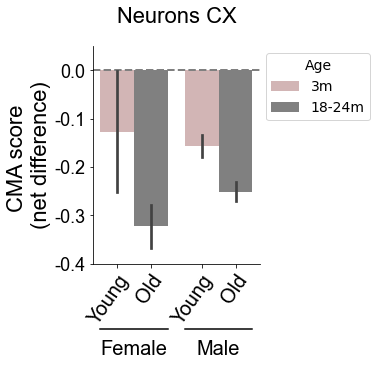

In [10]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[(barcode.cell_type=='neuron') & (barcode.subtissue=='Cortex') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.40, 0.05)
ax.set_yticks([-0.40, -0.30, -0.20, -0.10, 0.00])
ax.set_yticklabels([-0.40, -0.30, -0.20, -0.10, 0.00], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Neurons CX', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Neur_ns_sex_cx.png',bbox_inches='tight', dpi=300)

plt.show()

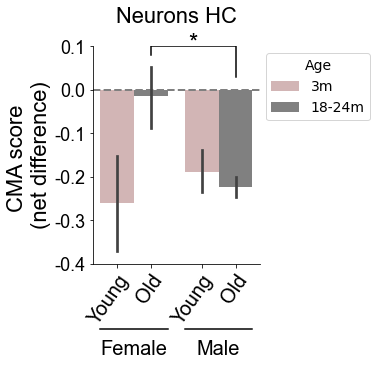

In [11]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[(barcode.cell_type=='neuron') & (barcode.subtissue=='Hippocampus')], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.40, 0.10)
ax.set_yticks([-0.40, -0.30, -0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.40, -0.30, -0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Neurons HC', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

# statistical annotation
x1, x2 = 0.2, 1.2   
y, h, col = 0.08 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, 0.03], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

plt.savefig('../Khwaja_et_al_outputs/Brain/Neur_ns_sex_hc.png',bbox_inches='tight', dpi=300)

plt.show()

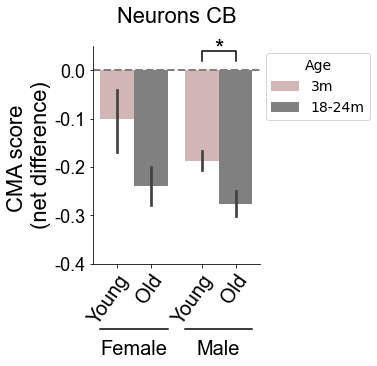

In [12]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[(barcode.cell_type=='neuron') & (barcode.subtissue=='Cerebellum')], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.40, 0.05)
ax.set_yticks([-0.40, -0.30, -0.20, -0.10, 0.00])
ax.set_yticklabels([-0.40, -0.30, -0.20, -0.10, 0.00], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Neurons CB', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.02 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

plt.savefig('../Khwaja_et_al_outputs/Brain/Neur_ns_sex_cb.png',bbox_inches='tight', dpi=300)

plt.show()

#### Interneurons: Cerebellum

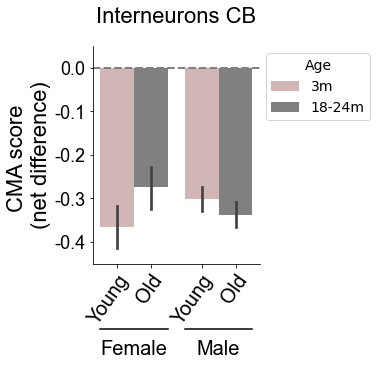

In [22]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[(barcode.cell_type=='interneuron') & (barcode.subtissue=='Cerebellum')], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.45, 0.05)
ax.set_yticks([-0.40, -0.30, -0.20, -0.10, 0.00])
ax.set_yticklabels([-0.40, -0.30, -0.20, -0.10, 0.00], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Interneurons CB', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Interneur_ns_sex_cb.png',bbox_inches='tight', dpi=300)

plt.show()

#### Astrocytes: Cortex, hippocampus and cerebellum

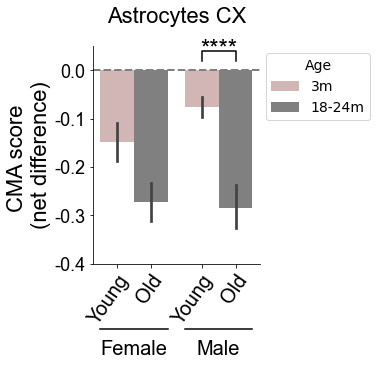

In [13]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[(barcode.cell_type=='astrocyte') & (barcode.subtissue=='Cortex') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.40, 0.05)
ax.set_yticks([-0.40, -0.30, -0.20, -0.10, 0.00])
ax.set_yticklabels([-0.40, -0.30, -0.20, -0.10, 0.00], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Astrocytes CX', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.02 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

plt.savefig('../Khwaja_et_al_outputs/Brain/Ast_ns_sex_cx.png',bbox_inches='tight', dpi=300)

plt.show()

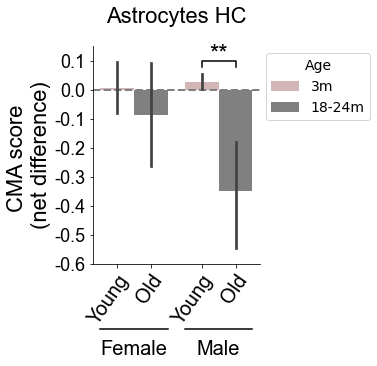

In [14]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[(barcode.cell_type=='astrocyte') & (barcode.subtissue=='Hippocampus')], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.60, 0.15)
ax.set_yticks([-0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.60, -0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Astrocytes HC', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.08 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "**", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

plt.savefig('../Khwaja_et_al_outputs/Brain/Ast_ns_sex_hc.png',bbox_inches='tight', dpi=300)

plt.show()

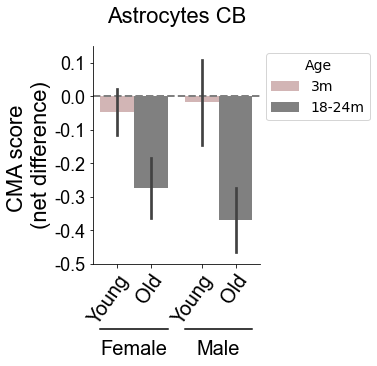

In [15]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[(barcode.cell_type=='astrocyte') & (barcode.subtissue=='Cerebellum')], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.50, 0.15)
ax.set_yticks([-0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.50, -0.40, -0.30, -0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Astrocytes CB', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Ast_ns_sex_cb.png',bbox_inches='tight', dpi=300)

plt.show()

#### Oligodendrocytes: Cortex, hippocampus and cerebellum

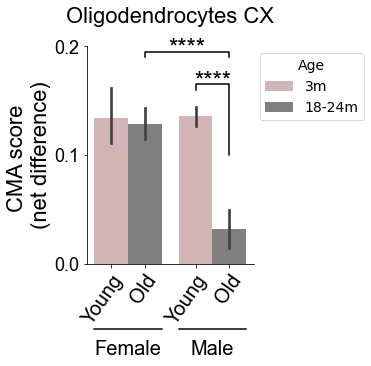

In [23]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[(barcode.cell_type=='oligodendrocyte') & (barcode.subtissue=='Cortex') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0.0, 0.20)
ax.set_yticks([0.00, 0.10, 0.20])
ax.set_yticklabels([0.00, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Oligodendrocytes CX', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.16 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, 0.10], lw=1.5, c=col)
plt.text((x1+x2)*.5, 0.157, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.19 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.003, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

plt.savefig('../Khwaja_et_al_outputs/Brain/Olig_ns_sex_cx.png',bbox_inches='tight', dpi=300)

plt.show()

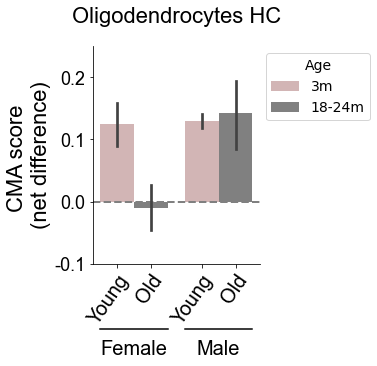

In [24]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[(barcode.cell_type=='oligodendrocyte') & (barcode.subtissue=='Hippocampus')], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.25)
ax.set_yticks([-0.10, 0.00, 0.10, 0.20])
ax.set_yticklabels([-0.10, 0.00, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Oligodendrocytes HC', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Olig_ns_sex_hc.png',bbox_inches='tight', dpi=300)

plt.show()

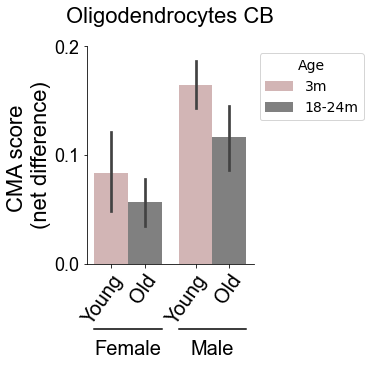

In [25]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[(barcode.cell_type=='oligodendrocyte') & (barcode.subtissue=='Cerebellum')], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0.0, 0.20)
ax.set_yticks([0.00, 0.10, 0.20])
ax.set_yticklabels([0.00, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Oligodendrocytes CB', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Olig_ns_sex_cb.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data (fold over whole tissue)

In [26]:
# Extracting raw values for bar graphs graphic
def raw (tipos, zona, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []
    area = []
    for i in tipos:
        for a in zona:
            for x in edad:
                for y in sex:
                    n = len(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
                            [barcode['sex']== y].index)
                    m = np.mean(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
                                [barcode['sex']== y]['net_score'])
                    s = stats.sem(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
                                  [barcode['sex']== y]['net_score'])

                    long.append(n)
                    celula.append(i)                
                    age.append(x)
                    sexo.append(y)
                    mean.append(m)
                    sem.append(s)
                    area.append(a)
                    
    df_raw = pd.DataFrame({"Cell_type": celula, "Region":area, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Brain/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Nsbysexreg", index=False)
    return(df_raw)

In [27]:
raw(tipos = cells, zona=areas, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\3947548156.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\3947548156.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\3947548156.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
C:\Users\Adrian\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Adrian\AppData\Roaming\Python\Python38\site-packages\numpy\core\

,Cell_type,Region,Age,Sex,n,Mean,SEM
0,neuron,Cortex,3m,female,4,-0.126785,0.127237
1,neuron,Cortex,3m,male,38,-0.156181,0.023677
2,neuron,Cortex,18-24m,female,29,-0.322873,0.045886
3,neuron,Cortex,18-24m,male,107,-0.250766,0.021161
4,neuron,Hippocampus,3m,female,4,-0.261104,0.106909
5,neuron,Hippocampus,3m,male,12,-0.189829,0.051466
6,neuron,Hippocampus,18-24m,female,8,-0.014811,0.075198
7,neuron,Hippocampus,18-24m,male,71,-0.223463,0.023282
8,neuron,Cerebellum,3m,female,11,-0.101342,0.069133
9,neuron,Cerebellum,3m,male,81,-0.186445,0.018373


### Graphs (fold over cell type)

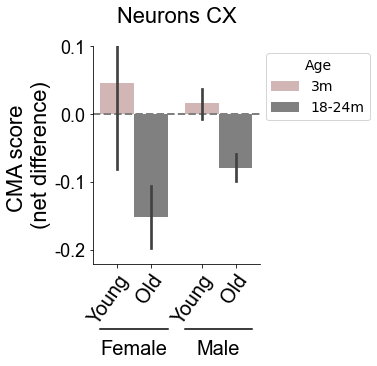

In [26]:
# Figure Neurons CX
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='neuron') & (barcode.subtissue=='Cortex') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.22, 0.10)
ax.set_yticks([-0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Neurons CX', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Neur_cellns_sex_cx.png',bbox_inches='tight', dpi=300)

plt.show()

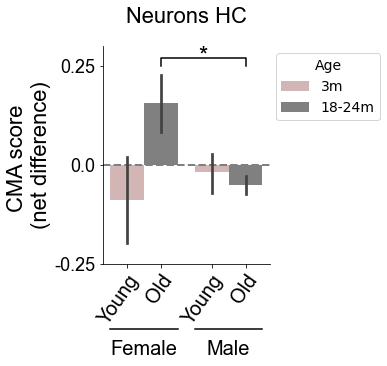

In [27]:
# Figure Neuron HC
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='neuron') & (barcode.subtissue=='Hippocampus') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.25, 0.30)
ax.set_yticks([-0.25, 0.00, 0.25])
ax.set_yticklabels([-0.25, 0.00, 0.25], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Neurons HC', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.2, 1.2   
y, h, col = 0.25 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.005, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Neur_cellns_sex_hc.png',bbox_inches='tight', dpi=300)

plt.show()

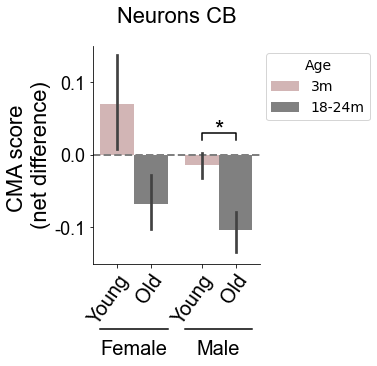

In [36]:
# Figure Neuron CB
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='neuron') & (barcode.subtissue=='Cerebellum') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.15)
ax.set_yticks([-0.10, 0.0, 0.10])
ax.set_yticklabels([-0.10, 0.0, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Neurons CB', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.02 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.003, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Neur_cellns_sex_cb.png',bbox_inches='tight', dpi=300)

plt.show()

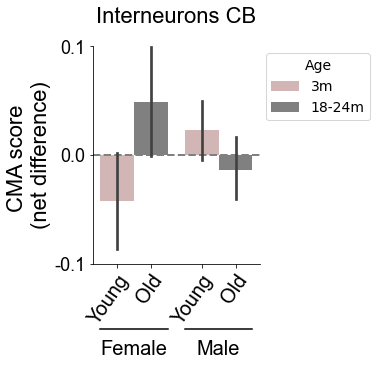

In [39]:
# Figure Interneuron CB
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='interneuron') & (barcode.subtissue=='Cerebellum') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.1, 0.1)
ax.set_yticks([-0.10, 0.0, 0.10])
ax.set_yticklabels([-0.10, 0.0, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Interneurons CB', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Interneur_cellns_sex_cb.png',bbox_inches='tight', dpi=300)

plt.show()

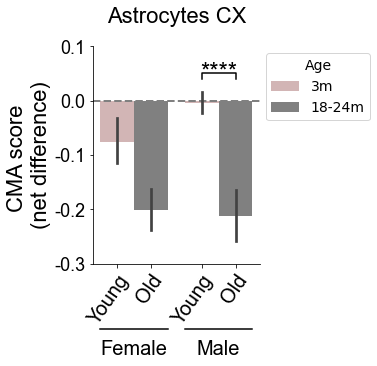

In [44]:
# Figure Astrocyte cx
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='astrocyte') & (barcode.subtissue=='Cortex') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.30, 0.10)
ax.set_yticks([-0.30, -0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.30, -0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Astrocytes CX', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.04 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.01, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Ast_cellns_sex_cx.png',bbox_inches='tight', dpi=300)

plt.show()

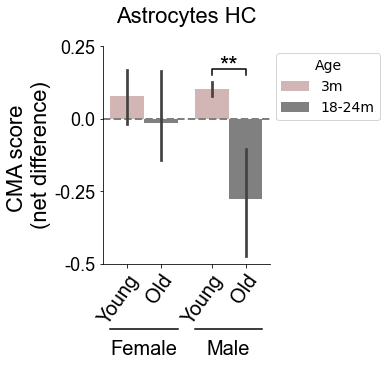

In [46]:
# Figure Astrocyte HC
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='astrocyte') & (barcode.subtissue=='Hippocampus') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.50, 0.25)
ax.set_yticks([-0.50, -0.25, 0.00, 0.25])
ax.set_yticklabels([-0.50, -0.25, 0.00, 0.25], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Astrocytes HC', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.15 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.01, "**", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Ast_cellns_sex_hc.png',bbox_inches='tight', dpi=300)

plt.show()

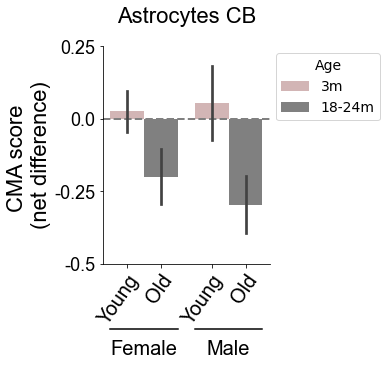

In [49]:
# Figure Astrocyte CB
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='astrocyte') & (barcode.subtissue=='Cerebellum') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.50, 0.25)
ax.set_yticks([-0.50, -0.25, 0.00, 0.25])
ax.set_yticklabels([-0.50, -0.25, 0.00, 0.25], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Astrocytes CB', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Ast_cellns_sex_cb.png',bbox_inches='tight', dpi=300)

plt.show()

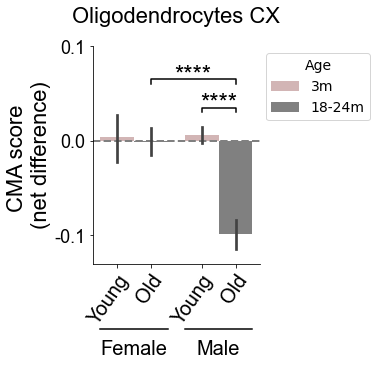

In [63]:
# Figure Oligodendrocytes cx
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='oligodendrocyte') & (barcode.subtissue=='Cortex')], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.13, 0.10)
ax.set_yticks([-0.10, 0.00, 0.10])
ax.set_yticklabels([-0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Oligodendrocytes CX', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, 0.027, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.06 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.003, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Olig_cellns_sex_cx.png',bbox_inches='tight', dpi=300)

plt.show()

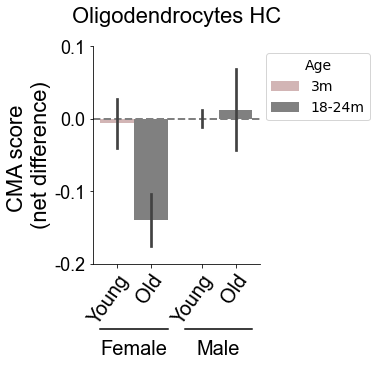

In [70]:
# Figure oligodendrocyte HC
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='oligodendrocyte') & (barcode.subtissue=='Hippocampus') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.20, 0.10)
ax.set_yticks([-0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Oligodendrocytes HC', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Olig_cellns_sex_hc.png',bbox_inches='tight', dpi=300)

plt.show()

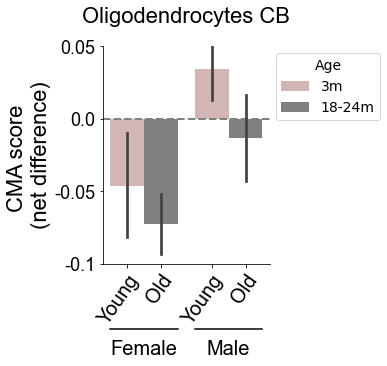

In [74]:
# Figure oligodendrocyte CB
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[(barcode.cell_type=='oligodendrocyte') & (barcode.subtissue=='Cerebellum') ], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.05)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Oligodendrocytes CB', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Olig_cellns_sex_cb.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data (fold over cell types)

In [75]:
# Extracting raw values for bar graphs graphic
def raw (tipos, zona, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []
    area = []
    for i in tipos:
        for a in zona:
            for x in edad:
                for y in sex:
                    n = len(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
                            [barcode['sex']== y].index)
                    m = np.mean(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
                                [barcode['sex']== y]['celltype_ns'])
                    s = stats.sem(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
                                  [barcode['sex']== y]['celltype_ns'])

                    long.append(n)
                    celula.append(i)                
                    age.append(x)
                    sexo.append(y)
                    mean.append(m)
                    sem.append(s)
                    area.append(a)
                    
    df_raw = pd.DataFrame({"Cell_type": celula, "Region":area, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Brain/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="CellNsbysexreg", index=False)
    return(df_raw)

In [76]:
raw(tipos = cells, zona=areas, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\1331794397.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\1331794397.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\1331794397.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['cell_type']== i][barcode['subtissue']== a][barcode['new_age']== x]
C:\Users\Adrian\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Adrian\AppData\Roaming\Python\Python38\site-packages\numpy\core\_me

,Cell_type,Region,Age,Sex,n,Mean,SEM
0,neuron,Cortex,3m,female,4,0.045371,0.127237
1,neuron,Cortex,3m,male,38,0.015974,0.023677
2,neuron,Cortex,18-24m,female,29,-0.150718,0.045886
3,neuron,Cortex,18-24m,male,107,-0.078610,0.021161
4,neuron,Hippocampus,3m,female,4,-0.088948,0.106909
5,neuron,Hippocampus,3m,male,12,-0.017674,0.051466
6,neuron,Hippocampus,18-24m,female,8,0.157345,0.075198
7,neuron,Hippocampus,18-24m,male,71,-0.051308,0.023282
8,neuron,Cerebellum,3m,female,11,0.070814,0.069133
9,neuron,Cerebellum,3m,male,81,-0.014290,0.018373


## Comparisons between regions

### Stats

In [98]:
# 2-way Anova for all cells by region
for i in ['neuron', 'astrocyte']:
    intdf = barcode[(barcode['cell_type']==i) & (barcode['subtissue']!='Cerebellum') & 
                    (barcode['subtissue']!='Striatum')].reset_index()    
    
    # 2-way Anova
    model = ols('celltype_ns ~ C(new_age) + C(subtissue) + C(new_age):C(subtissue)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.subtissue.astype(str)
    comp = mc.MultiComparison(intdf['celltype_ns'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Neuron 2-way Anova

                            df     sum_sq   mean_sq         F    PR(>F)
C(new_age)                 1.0   0.252463  0.252463  5.795395  0.016742
C(subtissue)               7.0   0.345269  0.049324  1.132253  0.342981
C(new_age):C(subtissue)    7.0   0.181198  0.025885  0.594209  0.760490
Residual                 269.0  11.718387  0.043563       NaN       NaN


Neuron Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
       group1               group2          stat   pval  pval_corr reject
-------------------------------------------------------------------------
     18-24m & Cortex 18-24m & Hippocampus -2.0581 0.0408    0.2448  False
     18-24m & Cortex          3m & Cortex -3.0164 0.0029    0.0176   True
     18-24m & Cortex     3m & Hippocampus -0.9958 0.3209       1.0  False
18-24m & Hippocampus          3m & Cortex -1.3471 0.1805       1.0  False
18-24m & Hippocampus     3m & Hippocampus  0.0956 0.9

In [107]:
# 2-way Anova for all cells by region in interneurons
for i in ['Cerebellum']:
    newdf = barcode[barcode['subtissue']==i].reset_index()  
    intdf = newdf[(newdf['cell_type']=='neuron') | (newdf['cell_type']=='interneuron')]
    print(len(list(intdf.index)))
    print('\n')
    
    # 2-way Anova
    model = ols('celltype_ns ~ C(new_age) + C(cell_type) + C(new_age):C(cell_type)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.cell_type.astype(str)
    comp = mc.MultiComparison(intdf['celltype_ns'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

357


Cerebellum 2-way Anova

                            df     sum_sq   mean_sq         F    PR(>F)
C(new_age)                 1.0   0.159347  0.159347  3.501758  0.062131
C(cell_type)              16.0   0.775988  0.048499  1.065802  0.386807
C(new_age):C(cell_type)   16.0   0.783317  0.048957  1.075869  0.376726
Residual                 353.0  16.063228  0.045505       NaN       NaN


Cerebellum Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
       group1             group2        stat   pval  pval_corr reject
---------------------------------------------------------------------
18-24m & interneuron  18-24m & neuron  2.6243 0.0094    0.0566  False
18-24m & interneuron 3m & interneuron -0.0523 0.9583       1.0  False
18-24m & interneuron      3m & neuron  0.0732 0.9418       1.0  False
     18-24m & neuron 3m & interneuron -2.7353 0.0069    0.0414   True
     18-24m & neuron      3m & neuron -3.0071  0.003    0.0181 

### Excitatory Neurons CX vs HC

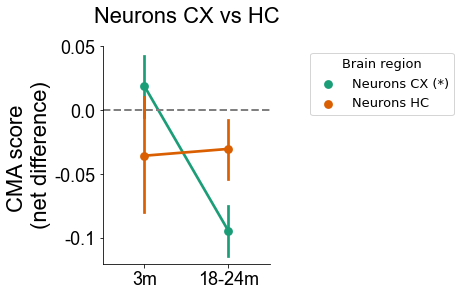

In [112]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='celltype_ns', data=barcode[barcode.cell_type=='neuron'], hue='subtissue', 
              order=["3m", "18-24m"], hue_order=['Cortex', 'Hippocampus'], palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.12, 0.05) 
ax.set_yticks([-0.10, -0.05, 0.00, 0.05])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})

# Legend
leyenda = ['Neurons CX (*)', 'Neurons HC']
h, l = ax.get_legend_handles_labels()
ax.legend(h, leyenda, bbox_to_anchor=(1.2, 1), title="Brain region", title_fontsize = "13", fontsize=13) 

plt.title(label='Neurons CX vs HC', fontdict={'family':'Arial', 'size': 22}, y=1.08)

plt.savefig('../Khwaja_et_al_outputs/Brain/Neur_cellns_cxvshc.png',bbox_inches='tight', dpi=300)

plt.show()

### Cerebellum Neurons vs interneurons

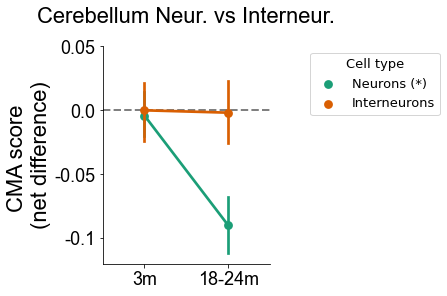

In [111]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='celltype_ns', data=barcode[(barcode.subtissue=='Cerebellum')], hue='cell_type', 
              order=["3m", "18-24m"], hue_order=['neuron', 'interneuron'], palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.12, 0.05) 
ax.set_yticks([-0.10, -0.05, 0.00, 0.05])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})

# Legend(
leyenda = ['Neurons (*)', 'Interneurons']
h, l = ax.get_legend_handles_labels()
ax.legend(h, leyenda, bbox_to_anchor=(1.2, 1), title="Cell type", title_fontsize = "13", fontsize=13) 

plt.title(label='Cerebellum Neur. vs Interneur.', fontdict={'family':'Arial', 'size': 22}, y=1.08)

plt.savefig('../Khwaja_et_al_outputs/Brain/CB_cellns_neurvsinterneur.png',bbox_inches='tight', dpi=300)

plt.show()

### Astrocytes CX vs HC

C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\549741342.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y1 = np.mean(barcode[barcode.cell_type=='astrocyte'][barcode.subtissue=='Cortex'][barcode.new_age=='3m']['celltype_ns'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\549741342.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y2 = np.mean(barcode[barcode.cell_type=='astrocyte'][barcode.subtissue=='Hippocampus'][barcode.new_age=='3m']['celltype_ns'])


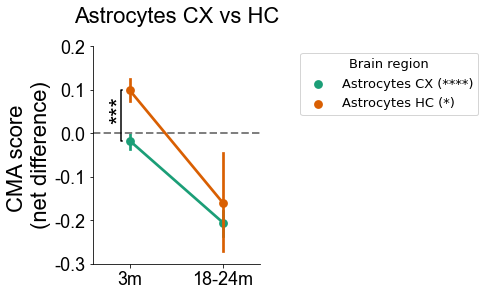

In [130]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='celltype_ns', data=barcode[barcode.cell_type=='astrocyte'], hue='subtissue', 
              order=["3m", "18-24m"], hue_order=['Cortex', 'Hippocampus'], palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.xlim(-0.40, 1.4)
plt.ylim(-0.30, 0.2) 
ax.set_yticks([-0.30, -0.20, -0.10, 0.00, 0.10, 0.20])
ax.set_yticklabels([-0.30, -0.20, -0.10, 0.00, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})

# Legend
leyenda = ['Astrocytes CX (****)', 'Astrocytes HC (*)']
h, l = ax.get_legend_handles_labels()
ax.legend(h, leyenda, bbox_to_anchor=(1.2, 1), title="Brain region", title_fontsize = "13", fontsize=13) 

plt.title(label='Astrocytes CX vs HC', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x, h, col = -0.1, 0.02, 'k' 
y1 = np.mean(barcode[barcode.cell_type=='astrocyte'][barcode.subtissue=='Cortex'][barcode.new_age=='3m']['celltype_ns'])
y2 = np.mean(barcode[barcode.cell_type=='astrocyte'][barcode.subtissue=='Hippocampus'][barcode.new_age=='3m']['celltype_ns'])
plt.plot([x+h, x,x, x+h], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(-0.23, y-0.005, "***", rotation=90, va='center', color=col, fontdict={'family':'Arial', 'size': 24})

plt.savefig('../Khwaja_et_al_outputs/Brain/Ast_cellns_cxvshc.png',bbox_inches='tight', dpi=300)

plt.show()

In [136]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, reg):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    region = []

    for i in tipos:
        for x in edad:
            for y in reg:
                if i == 'astrocyte' and y=='Cerebellum':
                    continue
                elif i == 'interneuron' and y == 'Cortex':
                    continue
                elif i == 'interneuron' and y == 'Hippocampus':
                    continue
                else:
                    n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['subtissue']== y].index)
                    m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['subtissue']== y]['celltype_ns'])
                    s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['subtissue']== y]['celltype_ns'])

                    long.append(n)
                    celula.append(i)                
                    age.append(x)
                    region.append(y)
                    mean.append(m)
                    sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Subtissue":region, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Brain/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Regionvs", index=False)
    return(df_raw)

In [137]:
raw(tipos=['neuron', 'interneuron', 'astrocyte'], edad=['3m', '18-24m'], reg=areas)

C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\3737146209.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['subtissue']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\3737146209.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['subtissue']== y]['celltype_ns'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_8108\3737146209.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['subtissue']== y]['celltype_ns'])


,Cell_type,Age,Subtissue,n,Mean,SEM
0,neuron,3m,Cortex,42,1.877378e-02,0.023924
1,neuron,3m,Hippocampus,16,-3.549239e-02,0.045736
2,neuron,3m,Cerebellum,92,-4.114159e-03,0.018233
3,neuron,18-24m,Cortex,136,-9.398603e-02,0.019396
4,neuron,18-24m,Hippocampus,79,-3.017845e-02,0.023225
5,neuron,18-24m,Cerebellum,88,-8.991299e-02,0.022085
6,interneuron,3m,Cerebellum,83,1.404499e-17,0.024440
7,interneuron,18-24m,Cerebellum,94,-1.840528e-03,0.025038
8,astrocyte,3m,Cortex,273,-1.721880e-02,0.018201
9,astrocyte,3m,Hippocampus,95,9.864731e-02,0.025166


## CMA network heatmaps by cell type & sex

In [29]:
# Load matrix reordered
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx', 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [35]:
def sex_heatmaps(cellpop, region):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    # Find cell indices for each condition
    female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
                     [barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
                         [barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
                   [barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
                       [barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    # Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    # Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd        
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Brain/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name='{}_{}_heat'.format(cellpop, region), index=True)
    
    # Plot heatmap including all conditions and Removing NFATC1 in Astrocytes Cerebellum
    
    if cellpop == 'astrocyte' and region == 'Cerebellum':
        matrix_zs = np.delete(matrix_zs,(7), axis=0)
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        nonfat = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'GFAP', 'PHLPP1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']
        plt.yticks(np.arange(15), nonfat, fontsize=16, **hfont)

        plt.ylim(14.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.title(cellpop.title()+' '+region.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        
        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0.25), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.5, 4.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 9.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.5, 9.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[10, 14.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
        
    else:
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}

        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(15.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.title(cellpop.title()+' '+region.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)

        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    plt.savefig('../Khwaja_et_al_outputs/Brain/{}_sex_{}_heat.png'.format(cellpop,region),bbox_inches='tight', dpi=300)
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
100%|█████████████████████████████████████████████

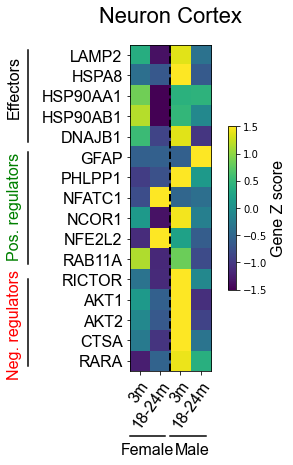

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
100%|█████████████████████████████████████████████

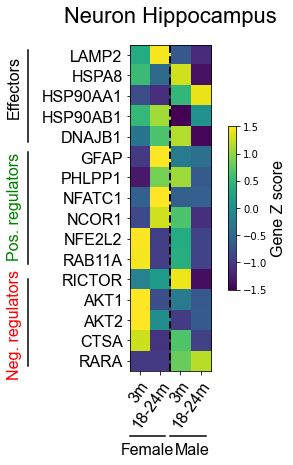

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
100%|█████████████████████████████████████████████

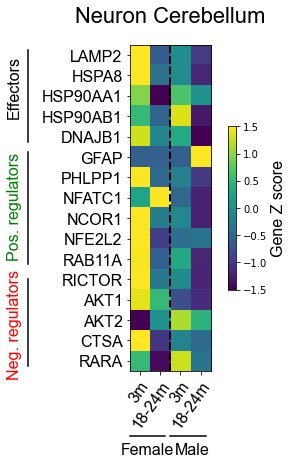

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
100%|█████████████████████████████████████████████

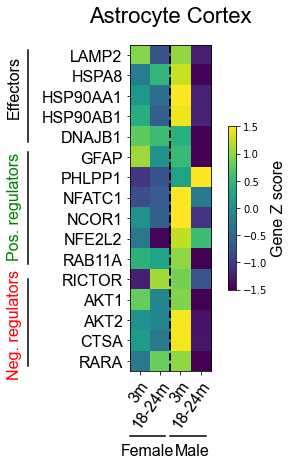

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
100%|█████████████████████████████████████████████

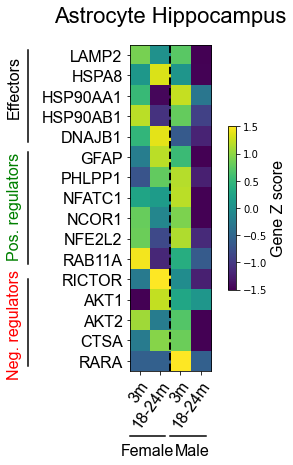

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
100%|█████████████████████████████████████████████

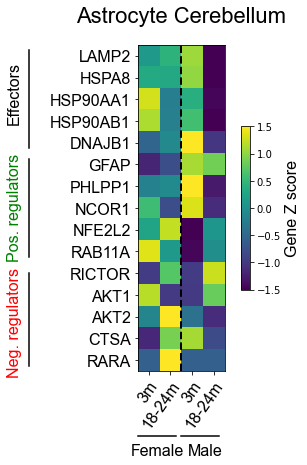

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
100%|█████████████████████████████████████████████

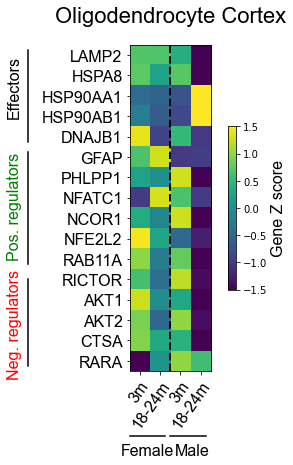

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
100%|█████████████████████████████████████████████

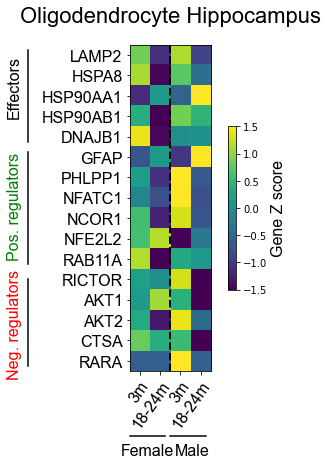

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
100%|█████████████████████████████████████████████

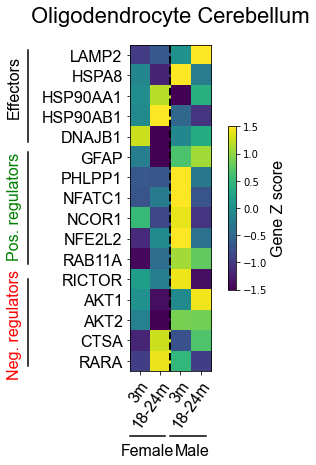

In [36]:
for i in ['neuron', 'astrocyte', 'oligodendrocyte']:
    for j in areas:
        sex_heatmaps(cellpop=i, region=j)

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\1293782681.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['subtissue'] == region]
100%|█████████████████████████████████████████████

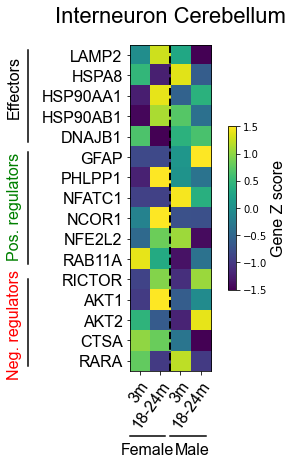

In [37]:
sex_heatmaps(cellpop='interneuron', region='Cerebellum')

## Ridge plots for L2 and L1

In [138]:
# Codes for L2 and L1
lys = ['ENSMUSG00000016534', 'ENSMUSG00000031447']

In [139]:
# Selecting only L2 and L1 from adata
adata_lys = adata[:, lys]
barcode_lys = adata.obs.copy()

# Calculating the Z score for L2 & L1
lys_zs = adata_lys.copy().X.todense()

for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ = np.mean(lys_zs[:, i])
    sd = np.std(lys_zs[:, i])
    
    lys_zs[:, i] = (lys_zs[:, i] - µ)/sd
    
# Converting lys_zs.X to a pandas df
df_lys = pd.DataFrame(lys_zs.tolist())
df_lys.rename(columns={0:"L2", 1:'L1'}, inplace=True)

# Generating barcode df and appending L2 column
barcode_lys = barcode_lys.reset_index()
barcode_lys = pd.concat([barcode_lys, df_lys], axis=1)
barcode_lys = barcode_lys [['index', 'cell', 'cell_type', 'sex', 'age', 'L2', 'L1']]

barcode_lys.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 992.85it/s]


,index,cell,cell_type,sex,age,L2,L1
0,C4_B001059_B009342_S52.mm10-plus-0-0,C4_B001059,oligodendrocyte,female,18m,0.121990,-1.290457
1,E10_B001059_B009342_S106.mm10-plus-0-0,E10_B001059,oligodendrocyte,female,18m,1.193545,-0.124637
2,E22_B001059_B009342_S118.mm10-plus-0-0,E22_B001059,"CD8-positive, alpha-beta T cell",female,18m,-0.969026,-0.199661
3,F5_B001059_B009342_S125.mm10-plus-0-0,F5_B001059,oligodendrocyte,female,18m,-0.969026,-1.200827
4,G18_B001059_B009342_S162.mm10-plus-0-0,G18_B001059,microglial cell,female,18m,-0.969026,0.974806


In [140]:
# Generating new ages
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'age'] == '3m':        
        barcode_lys.loc[j, 'new_age'] = '3m'

    elif barcode_lys.loc[j, 'age'] == '18m':                
        barcode_lys.loc[j, 'new_age'] = '18-24m'

    elif barcode_lys.loc[j, 'age'] == '24m': 
        barcode_lys.loc[j, 'new_age'] = '18-24m'
        
barcode_lys.head()

,index,cell,cell_type,sex,age,L2,L1,new_age
0,C4_B001059_B009342_S52.mm10-plus-0-0,C4_B001059,oligodendrocyte,female,18m,0.121990,-1.290457,18-24m
1,E10_B001059_B009342_S106.mm10-plus-0-0,E10_B001059,oligodendrocyte,female,18m,1.193545,-0.124637,18-24m
2,E22_B001059_B009342_S118.mm10-plus-0-0,E22_B001059,"CD8-positive, alpha-beta T cell",female,18m,-0.969026,-0.199661,18-24m
3,F5_B001059_B009342_S125.mm10-plus-0-0,F5_B001059,oligodendrocyte,female,18m,-0.969026,-1.200827,18-24m
4,G18_B001059_B009342_S162.mm10-plus-0-0,G18_B001059,microglial cell,female,18m,-0.969026,0.974806,18-24m


In [141]:
# Reducing df only to cells of interest
barcode_lys = barcode_lys[(barcode_lys.cell_type==cells[0]) | (barcode_lys.cell_type==cells[1])
                         | (barcode_lys.cell_type==cells[2]) | (barcode_lys.cell_type==cells[3])].reset_index()

### Graphs

#### Lamp2 female

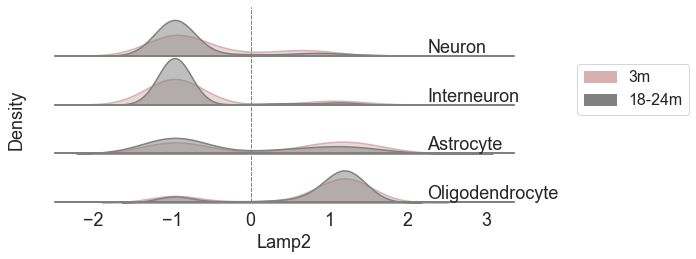

In [144]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)
g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.5, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=5.5, s="Neuron", fontsize=18) 
plt.text(x=2.25, y=3.7, s="Interneuron", fontsize=18) 
plt.text(x=2.25, y=1.93, s="Astrocyte", fontsize=18) 
plt.text(x=2.25, y=0.12, s="Oligodendrocyte", fontsize=18)  


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Brain/Brain_L2_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp2 male

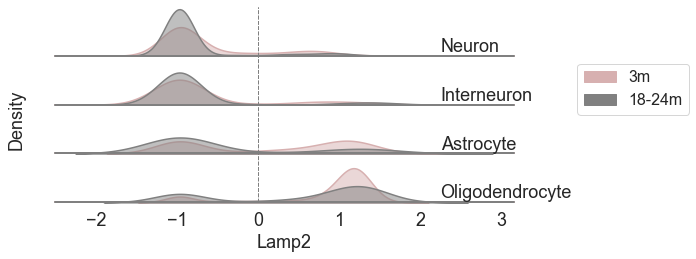

In [147]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)
g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.5, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=6.4, s="Neuron", fontsize=18) 
plt.text(x=2.25, y=4.3, s="Interneuron", fontsize=18) 
plt.text(x=2.25, y=2.25, s="Astrocyte", fontsize=18) 
plt.text(x=2.25, y=0.2, s="Oligodendrocyte", fontsize=18) 


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Brain/Brain_L2_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 female

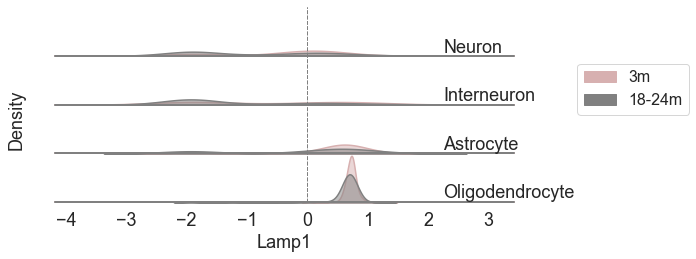

In [149]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)
g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.5, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=15.85, s="Neuron", fontsize=18) 
plt.text(x=2.25, y=10.75, s="Interneuron", fontsize=18) 
plt.text(x=2.25, y=5.55, s="Astrocyte", fontsize=18) 
plt.text(x=2.25, y=0.45, s="Oligodendrocyte", fontsize=18) 

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Brain/Brain_L1_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 male

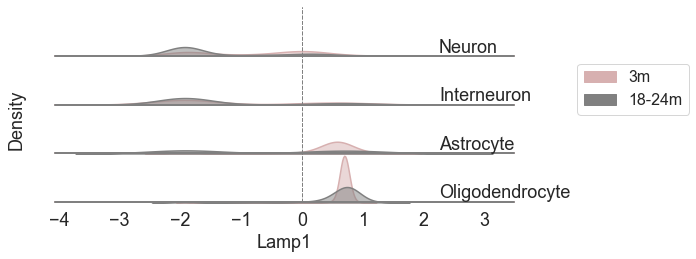

In [152]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)
g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.5, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=16, s="Neuron", fontsize=18) 
plt.text(x=2.25, y=10.85, s="Interneuron", fontsize=18) 
plt.text(x=2.25, y=5.6, s="Astrocyte", fontsize=18) 
plt.text(x=2.25, y=0.45, s="Oligodendrocyte", fontsize=18)  


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Brain/Brain_L1_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

## L2 Bar graphs

### Stats

In [64]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode_lys[barcode_lys['cell_type']==i].reset_index(drop=True)    
    
    # 2-way Anova
    model = ols('L2 ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['L2'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Neuron 2-way Anova

                      df      sum_sq   mean_sq         F    PR(>F)
C(new_age)           1.0    2.923570  2.923570  8.598065  0.003526
C(sex)               1.0    0.220890  0.220890  0.649626  0.420646
C(new_age):C(sex)    1.0    0.000118  0.000118  0.000348  0.985117
Residual           480.0  163.212727  0.340027       NaN       NaN


Neuron Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male  0.7328 0.4642       1.0  False
18-24m & female   3m & female -1.1131 0.2685       1.0  False
18-24m & female     3m & male -1.3234 0.1871       1.0  False
  18-24m & male   3m & female -1.7857 0.0753    0.4516  False
  18-24m & male     3m & male -2.8111 0.0052    0.0311   True
    3m & female     3m & male  0.3678 0.7135       1.0  False
--------------------------

### Graphs

In [65]:
sns.reset_defaults()

#### Neurons

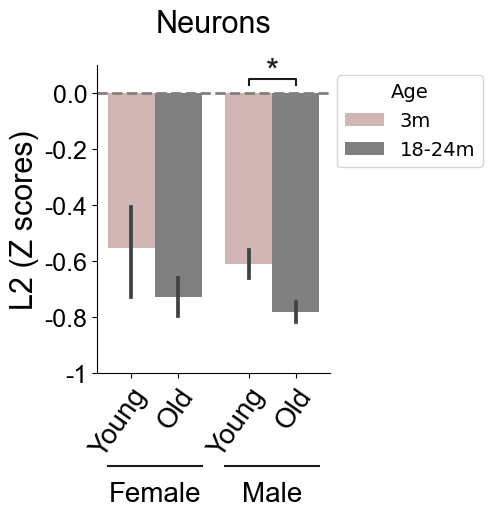

In [89]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.cell_type=='neuron'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-1, 0.10)
ax.set_yticks([-1, -0.8, -0.6, -0.4, -0.2, 0])
ax.set_yticklabels([-1, -0.8, -0.6, -0.4, -0.2, 0.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Neurons', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, h, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Neur_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Interneurons

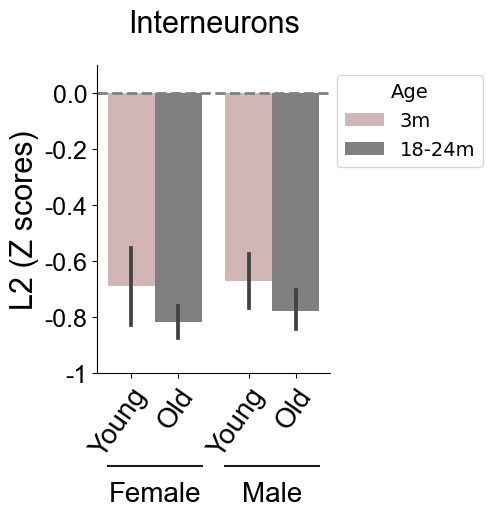

In [88]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.cell_type=='interneuron'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-1, 0.10)
ax.set_yticks([-1, -0.8, -0.6, -0.4, -0.2, 0])
ax.set_yticklabels([-1, -0.8, -0.6, -0.4, -0.2, 0.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Interneurons', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Interneur_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Astrocytes

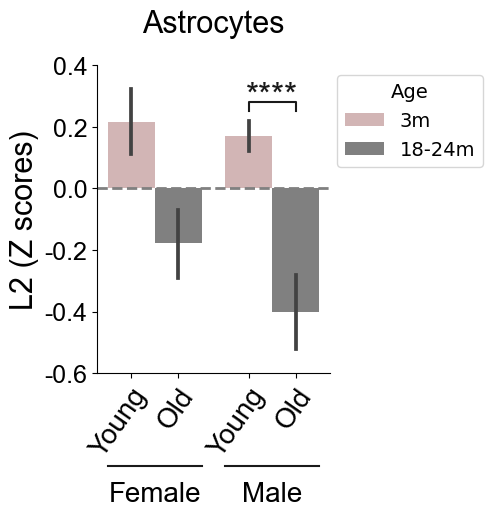

In [87]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.cell_type=='astrocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.6, 0.40)
ax.set_yticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4])
ax.set_yticklabels([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Astrocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.25, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Ast_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Oligodendrocytes

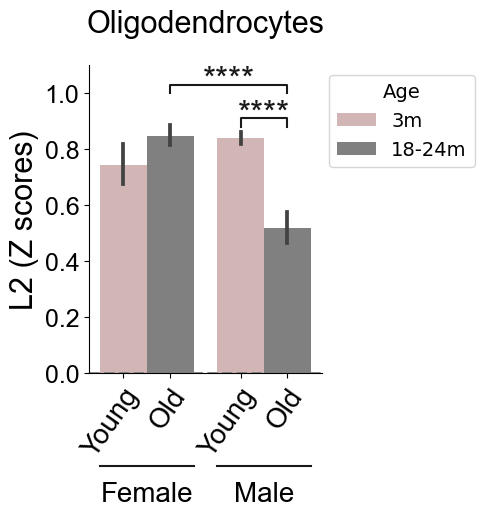

In [107]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.cell_type=='oligodendrocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0, 1.1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Oligodendrocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.88, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, 0.87, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 1, 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, 0.99, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Brain/Olig_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [108]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
                m = np.mean(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
                s = stats.sem(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Brain/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="L2bysex", index=False)
    return(df_raw)

In [109]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\363463043.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\363463043.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_20792\363463043.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])


,Cell_type,Age,Sex,n,Mean,SEM
0,neuron,3m,female,20,-0.553719,0.152148
1,neuron,3m,male,134,-0.609957,0.054557
2,neuron,18-24m,female,76,-0.728518,0.069971
3,neuron,18-24m,male,254,-0.781784,0.033811
4,interneuron,3m,female,29,-0.687907,0.133204
5,interneuron,3m,male,54,-0.669371,0.095125
6,interneuron,18-24m,female,81,-0.816482,0.057094
7,interneuron,18-24m,male,76,-0.776453,0.072586
8,astrocyte,3m,female,102,0.215560,0.105070
9,astrocyte,3m,male,352,0.171067,0.051396
